In [ ]:
import os  # Add this line

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# User inputs
sOaMinSp = 10
seasonalAvailability = (
    1  # 1 if heating is only available in winter and cooling only available in summer
)

# Load data
ahu_data = pd.read_excel("ahu_1.xlsx", sheet_name="data")
t = pd.to_datetime(ahu_data.iloc[:, 0], format="%Y-%m-%d %H:%M:%S")
tSa = ahu_data.iloc[:, 1]  # Supply air temperature (°C)
tRa = ahu_data.iloc[:, 2]  # Return air temperature (°C)
tOa = ahu_data.iloc[:, 3]  # Outdoor air temperature (°C)
pSa = ahu_data.iloc[:, 4]  # Supply air pressure (Pa)
sOa = ahu_data.iloc[:, 5]  # Mixing box damper (%)
sHc = ahu_data.iloc[:, 6]  # Heating coil valve (%)
sCc = ahu_data.iloc[:, 7]  # Cooling coil valve (%)
sFan = ahu_data.iloc[:, 8]  # Fan status (%)

# Load zone data
zone_files = [
    file for file in os.listdir() if file.startswith("zone_") and file.endswith(".xlsx")
]
zones = []

for file in zone_files:
    zone_data = pd.read_excel(file, sheet_name="data")
    tIn = zone_data.iloc[:, 0]  # Indoor temperature (°C)
    qFlo = zone_data.iloc[:, 1]  # Airflow rate (L/s)
    sRad = zone_data.iloc[:, 3]  # Radiator valve (%)
    sDmp = zone_data.iloc[:, 4]  # VAV terminal damper (%)
    zones.append({"tIn": tIn, "qFlo": qFlo, "sRad": sRad, "sDmp": sDmp})

# Seasonal adjustment
if seasonalAvailability == 1:
    sCc = np.where((t.dt.month > 4) & (t.dt.month < 10), sCc, 0)
    sHc = np.where((t.dt.month < 5) | (t.dt.month > 9), sHc, 0)
    sRad = [
        np.where((t.dt.month < 5) | (t.dt.month > 9), zone["sRad"], 0) for zone in zones
    ]


In [ ]:
# Define operational conditions
indOperating = (t.dt.weekday < 5) & (t.dt.hour > 7) & (t.dt.hour < 17) & (sFan == 1)
indHtg = (
    indOperating
    & (sHc > 0)
    & (tOa < tSa)
    & (sOa > sOaMinSp - 5)
    & (sOa < sOaMinSp + 5)
    & (sCc < 5)
)
indEcon = indOperating & (sHc < 5) & (tOa < tSa) & (sOa > sOaMinSp) & (sCc == 0)
indEconClg = (
    indOperating & (sHc < 5) & (tOa > tSa) & (tRa > tOa) & (sOa > 90) & (sCc > 0)
)
indClg = (
    indOperating
    & (sHc < 5)
    & (tOa > tSa)
    & (tRa > tSa)
    & (sOa > sOaMinSp - 5)
    & (sOa < sOaMinSp + 5)
    & (sCc > 0)
)
indNormal = indHtg | indEcon | indEconClg | indClg
indFault = indOperating & ~indNormal


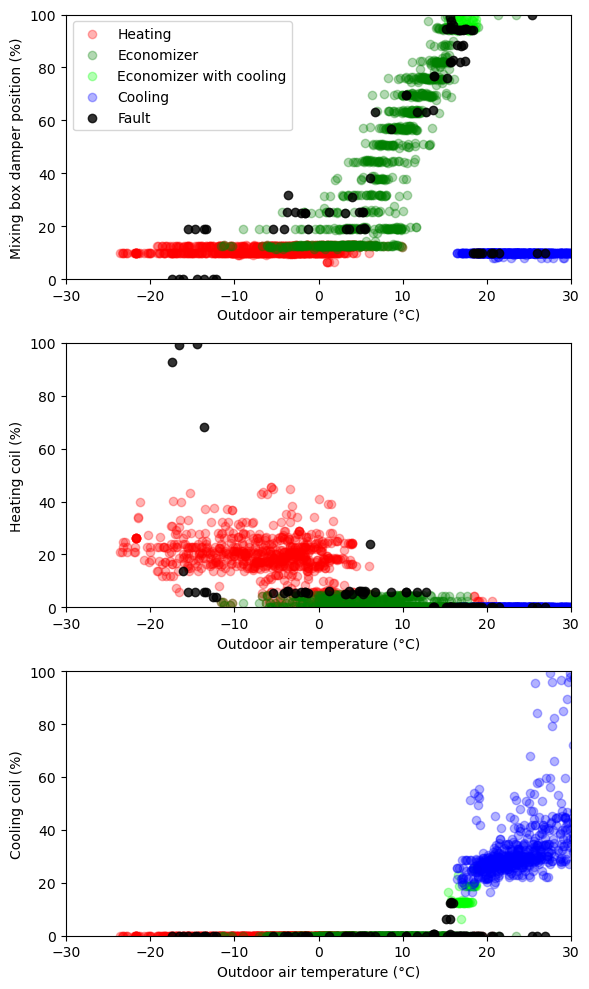

In [ ]:
# Plot state of operation
fig, axes = plt.subplots(3, 1, figsize=(6, 10))

axes[0].scatter(tOa[indHtg], sOa[indHtg], color="red", alpha=0.3, label="Heating")
axes[0].scatter(
    tOa[indEcon], sOa[indEcon], color="green", alpha=0.3, label="Economizer"
)
axes[0].scatter(
    tOa[indEconClg],
    sOa[indEconClg],
    color="lime",
    alpha=0.3,
    label="Economizer with cooling",
)
axes[0].scatter(tOa[indClg], sOa[indClg], color="blue", alpha=0.3, label="Cooling")
axes[0].scatter(tOa[indFault], sOa[indFault], color="black", alpha=0.8, label="Fault")
axes[0].set_xlim([-30, 30])
axes[0].set_ylim([0, 100])
axes[0].set_ylabel("Mixing box damper position (%)")
axes[0].set_xlabel("Outdoor air temperature (°C)")
axes[0].legend()

axes[1].scatter(tOa[indHtg], sHc[indHtg], color="red", alpha=0.3)
axes[1].scatter(tOa[indEcon], sHc[indEcon], color="green", alpha=0.3)
axes[1].scatter(tOa[indEconClg], sHc[indEconClg], color="lime", alpha=0.3)
axes[1].scatter(tOa[indClg], sHc[indClg], color="blue", alpha=0.3)
axes[1].scatter(tOa[indFault], sHc[indFault], color="black", alpha=0.8)
axes[1].set_xlim([-30, 30])
axes[1].set_ylim([0, 100])
axes[1].set_ylabel("Heating coil (%)")
axes[1].set_xlabel("Outdoor air temperature (°C)")

axes[2].scatter(tOa[indHtg], sCc[indHtg], color="red", alpha=0.3)
axes[2].scatter(tOa[indEcon], sCc[indEcon], color="green", alpha=0.3)
axes[2].scatter(tOa[indEconClg], sCc[indEconClg], color="lime", alpha=0.3)
axes[2].scatter(tOa[indClg], sCc[indClg], color="blue", alpha=0.3)
axes[2].scatter(tOa[indFault], sCc[indFault], color="black", alpha=0.8)
axes[2].set_xlim([-30, 30])
axes[2].set_ylim([0, 100])
axes[2].set_ylabel("Cooling coil (%)")
axes[2].set_xlabel("Outdoor air temperature (°C)")

fig.tight_layout()
plt.savefig("state_of_operation.png", dpi=600)

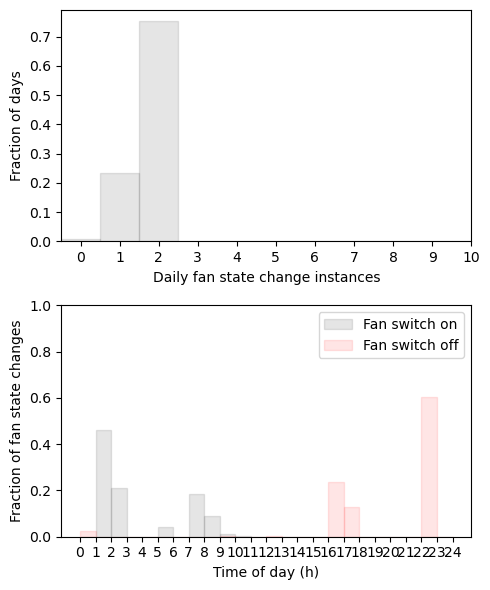

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming `t` and `sFan` are already loaded from previous code
timeOfDay = t.dt.hour
dayOfWeek = t.dt.weekday

# Prepare variables for storing state change data
numStateChange = []
timeOfSwitchOn = []
timeOfSwitchOff = []

# Calculate daily fan state changes and record switch on/off times
for i in range(
    int(t.min().floor("D").timestamp()), int(t.max().ceil("D").timestamp()), 86400
):  # 86400 sec = 1 day
    day_mask = (t >= pd.to_datetime(i, unit="s")) & (
        t < pd.to_datetime(i + 86400, unit="s")
    )
    fan_day = sFan[day_mask].values

    # Calculate number of fan state changes for the day
    numStateChange.append(np.sum(np.abs(np.diff(fan_day)) > 0.5))

    # Record times of switch on and off events
    time_diff = np.diff(fan_day)
    switch_on_times = timeOfDay[day_mask].iloc[:-1][time_diff > 0.5]
    switch_off_times = timeOfDay[day_mask].iloc[:-1][time_diff < -0.5]
    timeOfSwitchOn.extend(switch_on_times)
    timeOfSwitchOff.extend(switch_off_times)

# Convert lists to arrays for histogram plotting
timeOfSwitchOn = np.array(timeOfSwitchOn)
timeOfSwitchOff = np.array(timeOfSwitchOff)

# Plotting mode of operation
fig, axes = plt.subplots(2, 1, figsize=(5, 6))

# Histogram for daily fan state changes
edges = np.arange(-0.5, 11.5, 1)
axes[0].hist(
    numStateChange, bins=edges, density=True, color="black", alpha=0.1, edgecolor="k"
)
axes[0].set_xticks(range(11))
axes[0].set_xlim([-0.49, 10])
axes[0].set_xlabel("Daily fan state change instances")
axes[0].set_ylabel("Fraction of days")
axes[0].tick_params(direction="out")
axes[0].grid(False)

# Histogram for fan switch on/off times
edges = np.arange(0, 25, 1)
axes[1].hist(
    timeOfSwitchOn,
    bins=edges,
    density=True,
    color="black",
    alpha=0.1,
    edgecolor="k",
    label="Fan switch on",
)
axes[1].hist(
    timeOfSwitchOff,
    bins=edges,
    density=True,
    color="red",
    alpha=0.1,
    edgecolor="r",
    label="Fan switch off",
)
axes[1].set_xticks(range(25))
axes[1].set_ylim([0, 1])
axes[1].set_xlabel("Time of day (h)")
axes[1].set_ylabel("Fraction of fan state changes")
axes[1].legend(loc="upper right")
axes[1].tick_params(direction="out")
axes[1].grid(False)

plt.tight_layout()
plt.savefig("Mode_of_operation_updated.png", dpi=600)
plt.show()


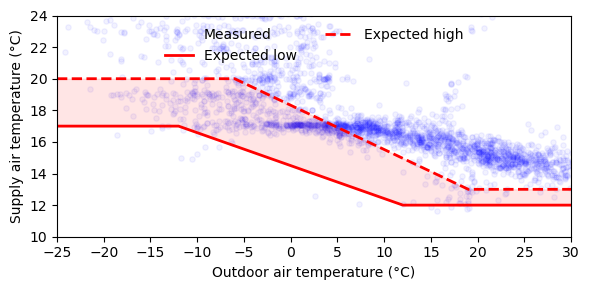

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

# Assuming the variables tOa, tSa, and other relevant data are already loaded from previous code
timeOfDay = t.dt.hour
dayOfWeek = t.dt.weekday

# Supply Air Temperature Setpoint Reset
fig, ax = plt.subplots(figsize=(6, 3), dpi=100)  # Adjusted width to 6 for a wider plot

# Filtering indices based on the conditions
ind = (
    (~tSa.isna())
    & (timeOfDay > 7)
    & (timeOfDay < 18)
    & (dayOfWeek > 1)
    & (dayOfWeek < 7)
)
ax.scatter(tOa[ind], tSa[ind], color="blue", alpha=0.05, s=15)

# Define the parameters and interpolation
handle = np.arange(-25, 31)
satResetPrmtr = np.array([[12, 17, 12, -12], [13, 20, 19, -6]])
store = []

for i in range(2):
    condition = (handle > satResetPrmtr[i, 2]) * satResetPrmtr[i, 0] + (
        handle < satResetPrmtr[i, 3]
    ) * satResetPrmtr[i, 1]
    interpolator = interp1d(
        [satResetPrmtr[i, 3], satResetPrmtr[i, 2]],
        [satResetPrmtr[i, 1], satResetPrmtr[i, 0]],
        fill_value="extrapolate",
    )
    tSaIdeal = np.where(condition == 0, interpolator(handle), condition)
    store.append(tSaIdeal)

# Plot expected lines and shaded area
store = np.array(store)
ax.plot(handle, store[0], "r", linewidth=2, label="Expected low")
ax.plot(handle, store[1], "r--", linewidth=2, label="Expected high")

# Shaded area between the expected lines
ax.fill_between(handle, store[0], store[1], color="red", alpha=0.1)

# Labeling
ax.set_xlabel("Outdoor air temperature (°C)")
ax.set_ylabel("Supply air temperature (°C)")
ax.set_xlim([-25, 30])
ax.set_ylim([10, 24])
ax.set_xticks(np.arange(-25, 31, 5))
ax.set_yticks(np.arange(10, 25, 2))
ax.legend(
    ["Measured", "Expected low", "Expected high"],
    ncol=2,
    loc="upper center",
    frameon=False,
)
plt.tight_layout()
plt.savefig("supply_air_temperature_wide.png", dpi=600)
plt.show()


C:\Users\alios\AppData\Local\Temp\ipykernel_25308\1457525540.py:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle((1, 0), 4, 1, color='red', alpha=0.1, edgecolor='red', linewidth=1)


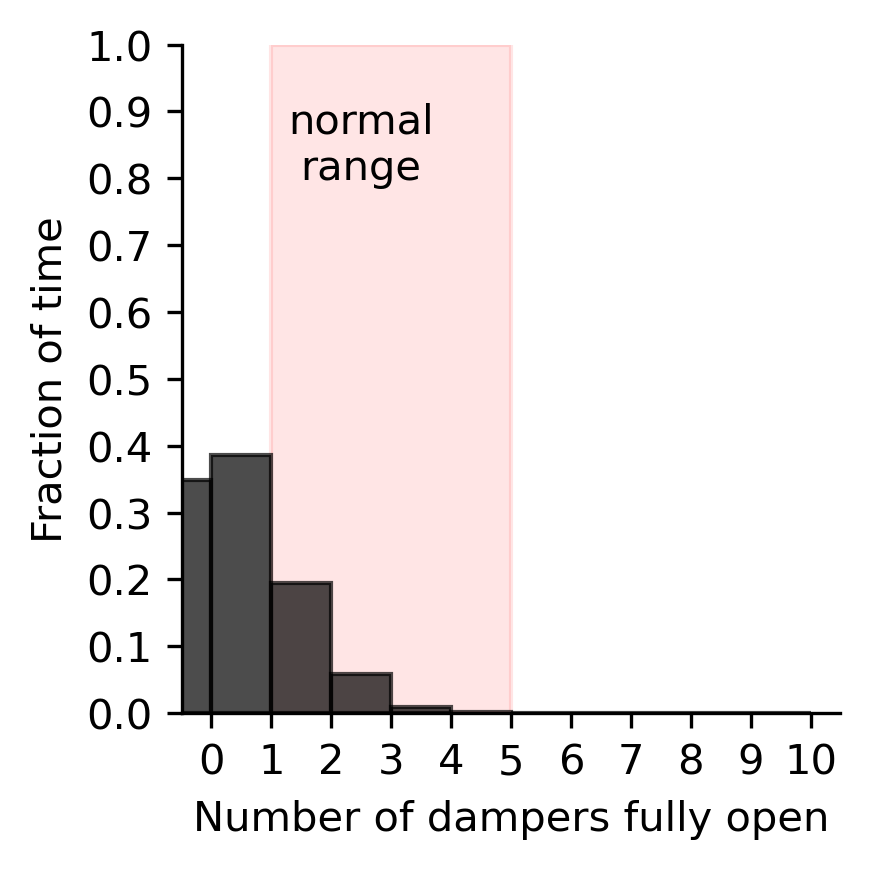

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data for the demonstration
np.random.seed(0)
num_samples = 8760  # Assume one year of hourly data
num_zones = 10  # Number of zones
sDmp = np.random.randint(0, 101, size=(num_samples, num_zones))  # Damper position data

# Define the `ind` filter (assuming all true here for simplicity)
ind = np.ones(num_samples, dtype=bool)

# Calculate number of fully open dampers
num_fully_open_dampers = np.sum(sDmp[ind, :] > 90, axis=1)

# Plotting the duct static pressure reset fault
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)

# Shaded normal range region starting from 1
rect = plt.Rectangle((1, 0), 4, 1, color="red", alpha=0.1, edgecolor="red", linewidth=1)
ax.add_patch(rect)
plt.text(2.5, 0.85, "normal\nrange", color="black", ha="center", va="center")

# Histogram of fully open dampers
hist_values, bin_edges = np.histogram(
    num_fully_open_dampers, bins=np.arange(-0.5, 11, 1), density=True
)
ax.bar(bin_edges[:-1], hist_values, width=1, color="black", alpha=0.7, edgecolor="k")

# Adjust x-axis and y-axis
ax.set_xticks(np.arange(0, 11, 1))
ax.set_xlim([-0.49, 10.49])
ax.set_ylim([0, 1])
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylabel("Fraction of time")
ax.set_xlabel("Number of dampers fully open")

# Aesthetic adjustments for MATLAB-like appearance
ax.tick_params(direction="out")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Show plot with tight layout
plt.tight_layout()
plt.savefig("duct_static_pressure_adjusted.png", dpi=600)
plt.show()
